In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np

bike_df = pd.read_csv('/media/adam/Data/DataSets/Divvy_Trips_2018_Q3.csv')

In [2]:
#df has 1.5M records; let's sample to get a more usable number
sample = bike_df.sample(n=5000)

#convert strings to useful values: datetime for dates, float for trip duration
sample['start_time'] = pd.to_datetime(sample['start_time'])
sample['end_time'] = pd.to_datetime(sample['end_time'])
sample['tripduration'] = sample['tripduration'].str.replace(',', '').astype(float)

# the "customer" field reports subscriber or customer (1x user)
# the "gender" field reports M / F for subscribers but the system doesn't collect information
# about "customers". This will replace the NaN values in the "gender" column with "customer".
sample['gender'].fillna('customer', inplace = True)


In [16]:
# create a pivot table that looks at the tripduration values, calculates their mean, and groups them by gender
trip_pivot = sample.pivot_table(values = 'tripduration',index = 'gender',aggfunc = np.mean, margins = True)

# convert the index into a column name
trip_pivot.reset_index(level=0,inplace = True)
trip_pivot['tripduration'] = round(trip_pivot['tripduration']/60,2)

In [17]:
trip_pivot

,gender,tripduration
0,Female,16.67
1,Male,15.03
2,customer,71.36
3,All,26.96


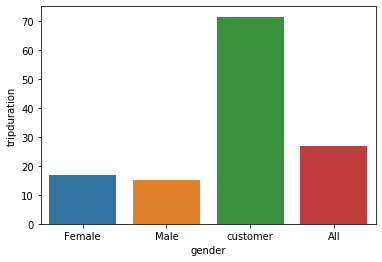

In [18]:
sns.barplot(x='gender',y='tripduration',data=trip_pivot)

Subscribers use the Divvy system differently: they ride, on average, about 15(m) to 16(f) minutes.
Customers ride about 71 minutes. 

In [21]:
stations = pd.read_csv('/media/adam/Data/DataSets/Divvy_Stations_2017_Q3Q4.csv')

def add_lat_long(ride_data,station_data):
    from geopy import distance

    ride_data = pd.merge(ride_data,station_data[['id','latitude','longitude']],'left',left_on = 'from_station_id',right_on = 'id')
    ride_data = pd.merge(ride_data,station_data[['id','latitude','longitude']],'left',left_on = 'to_station_id',right_on = 'id')
    ride_data = ride_data.drop(columns = ['id_x','id_y'])
    ride_data = ride_data.rename(columns={'latitude_x':'from_lat','longitude_x':'from_long',
                        'latitude_y':'to_lat','longitude_y':'to_long'})
    ride_data['distance'] = ride_data.apply(lambda row: (distance.distance((row.from_lat, row.from_long),(row.to_lat, row.to_long)).miles), axis='columns')

    return(ride_data)

sample = add_lat_long(sample,stations)

ValueError: ('Point coordinates must be finite. (nan, nan, 0.0) has been passed as coordinates.', 'occurred at index 234')

In [30]:
sample.head(3)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
225809,19504965,2018-07-13 23:09:02,2018-07-13 23:33:41,1858,1479.0,349,Halsted St & Wrightwood Ave,94,Clark St & Armitage Ave,Subscriber,Male,1984.0
160606,19430207,2018-07-10 14:56:03,2018-07-10 14:59:48,6403,225.0,432,Clark St & Lunt Ave,453,Clark St & Schreiber Ave,Subscriber,Male,1967.0
191208,19464940,2018-07-12 07:20:24,2018-07-12 07:37:15,2924,1011.0,508,Central Park Ave & North Ave,310,Damen Ave & Charleston St,Subscriber,Female,1990.0
